In [19]:
from src.main import main
from argparse import Namespace
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as patches
import matplotlib.colors as mcolors

In [2]:
maps = ['choices.map', 'mapa_teste.map', 'maze.map']
algorithms = ['standard', 'stochastic', 'positive']

test_cases1 = [
    Namespace(filename='maps/choices.map', mod_id='standard', xi=5, yi=0, n=3000000),
    Namespace(filename='maps/choices.map', mod_id='stochastic', xi=5, yi=0, n=3000000),
    Namespace(filename='maps/choices.map', mod_id='positive', xi=5, yi=0, n=3000000),
]

test_cases2 = [
    Namespace(filename='maps/mapa_teste.map', mod_id='standard', xi=0, yi=3, n=1000000),
    Namespace(filename='maps/mapa_teste.map', mod_id='stochastic', xi=0, yi=3, n=1000000),
    Namespace(filename='maps/mapa_teste.map', mod_id='positive', xi=0, yi=3, n=1000000),
]

test_cases3 = [
    Namespace(filename='maps/maze.map', mod_id='standard', xi=10, yi=0, n=3000000),
    Namespace(filename='maps/maze.map', mod_id='stochastic', xi=10, yi=0, n=3000000),
    Namespace(filename='maps/maze.map', mod_id='positive', xi=10, yi=0, n=3000000),
]

In [3]:
results = {
    'choices.map': {},
    'mapa_teste.map': {},
    'maze.map': {}
}

def run_tests(test_cases, results, map_name):
    for i, args in enumerate(test_cases):
        print(f"Running test case {i+1}: {args}")
        results[map_name][args.mod_id] = main(args)

run_tests(test_cases1, results, 'choices.map')
run_tests(test_cases2, results, 'mapa_teste.map')
run_tests(test_cases3, results, 'maze.map')


Running test case 1: Namespace(filename='maps/choices.map', mod_id='standard', xi=5, yi=0, n=3000000)
0 1
build options [ -8.69760953  -0.51312882   2.83546283 -10.22672345]
chosen index: 2 


0 2
build options [-17.06453713 -17.06453715   3.26162538   2.45191633]
chosen index: 2 


0 3
build options [-16.63837462   3.73513931   2.83546284   2.83546284]
chosen index: 1 


0 4
build options [-17.06453716 -10.           2.45191656   3.26162538]
chosen index: 3 


0 5
build options [-17.44808344 -17.44808344   2.1067249    2.83546284]
chosen index: 3 


0 6
build options [-17.79327504  -9.99999993   1.79604853   2.45191656]
chosen index: 3 


0 7
build options [-11.67311389  -0.26156904  -0.3906192    2.10672462]
chosen index: 3 


0 8
build options [-6.94001858 -5.47286084 -0.40184176  0.01687765]
chosen index: 3 


0 9
build options [-3.8160551  -0.39785167 -8.26012159 -0.40313795]
chosen index: 1 


1 1
build options [ 0.93435831 -0.19       -2.         -2.        ]
chosen index: 0 




In [4]:
def get_path(output_matrix, start_x, start_y):
    rows = len(output_matrix)
    cols = len(output_matrix[0])
    
    if not (0 <= start_x < rows and 0 <= start_y < cols):
        return []
    
    path = []
    visited = set()
    
    x, y = start_x, start_y
    while True:
        path.append((x, y))
        visited.add((x, y))
        
        symbol = output_matrix[x][y]
        
        if symbol in ('O', '@', 'x'):
            break
        
        if symbol == '^':
            x -= 1
        elif symbol == 'v':
            x += 1
        elif symbol == '>':
            y += 1
        elif symbol == '<':
            y -= 1
        else:
            break
        
        if not (0 <= x < rows and 0 <= y < cols):
            break
        
        if (x, y) in visited:
            path.append((x, y))
            break

    return path

In [5]:
def can_reach_goal(output_matrix, xi, yi) -> bool:
    path = get_path(output_matrix, xi, yi)
    
    for i in range(len(output_matrix)):
        for j in range(len(output_matrix[0])):
            if output_matrix[i][j] == 'O':
                coord = i,j
                break
    
    return coord in path

def can_reach_goal_full(output_matrix):
    list_reach = []
    
    for i in range(len(output_matrix)):
        for j in range(len(output_matrix[0])):
            if output_matrix[i][j] not in ('O', '@', 'x'):
                list_reach.append(can_reach_goal(output_matrix, i, j))
    
    return list_reach

def can_reach_score(output_matrix):
    list_reach = can_reach_goal_full(output_matrix)
    
    return sum(list_reach) / len(list_reach)

In [6]:
scores = {}

for map in maps:
    scores[map] = {}
    for alg in algorithms:
        scores[map][alg] = can_reach_score(results[map][alg])

scores

{'choices.map': {'standard': 0.8604651162790697,
  'stochastic': 0.18604651162790697,
  'positive': 0.0},
 'mapa_teste.map': {'standard': 1.0,
  'stochastic': 0.5,
  'positive': 0.42857142857142855},
 'maze.map': {'standard': 0.717391304347826,
  'stochastic': 0.2391304347826087,
  'positive': 0.0}}

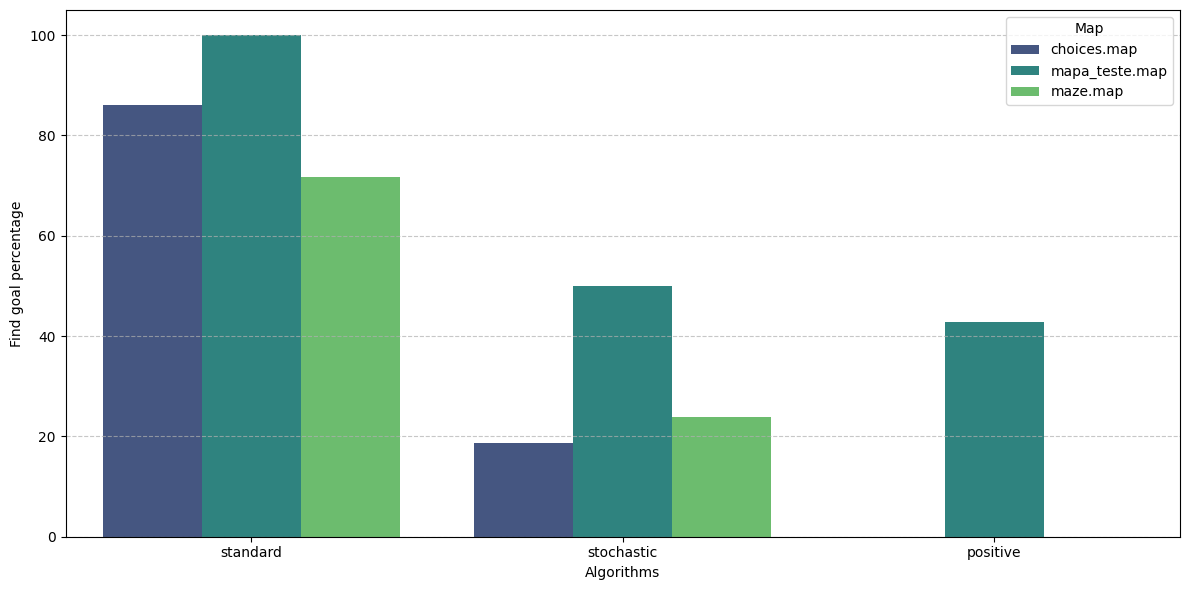

In [7]:
data = []

for map_name in maps:
    for alg, score in scores[map_name].items():
        data.append({"Category": f"{alg}", "Score": score*100, "Map": map_name})

df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
sns.barplot(x="Category", y="Score", hue="Map", data=df, palette="viridis", order=df["Category"])

plt.xlabel("Algorithms")
plt.ylabel("Find goal percentage")
plt.legend(title="Map", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()


In [20]:
def add_direction_triangle(ax, px, py, nx, ny, color='black'):
    """
    Draw a triangle in cell (px, py) pointing towards (nx, ny).
    px, py -> current cell (row, col)
    nx, ny -> next cell (row, col)
    color  -> color of the triangle
    """

    # The center of cell (px, py) in matplotlib coordinates is (py, px)
    # because `imshow` with origin='upper' uses col -> x, row -> y.
    cx = py
    cy = px
    
    # Direction vector (drow, dcol)
    drow = nx - px
    dcol = ny - py
    
    # We'll define a small offset for the tip, for example 0.25 from the center
    # and 0.2 for the width of the base. Feel free to adjust for visual clarity.
    tip_offset = 0.25
    base_offset = 0.2
    
    if drow == -1 and dcol == 0:
        # Move UP
        # Tip is above center, base is below
        tri_coords = [
            (cx, cy - tip_offset),                  # tip
            (cx - base_offset, cy + base_offset),   # base left
            (cx + base_offset, cy + base_offset)    # base right
        ]
    elif drow == 1 and dcol == 0:
        # Move DOWN
        tri_coords = [
            (cx, cy + tip_offset), 
            (cx - base_offset, cy - base_offset), 
            (cx + base_offset, cy - base_offset)
        ]
    elif drow == 0 and dcol == 1:
        # Move RIGHT
        tri_coords = [
            (cx + tip_offset, cy),
            (cx - base_offset, cy - base_offset),
            (cx - base_offset, cy + base_offset)
        ]
    elif drow == 0 and dcol == -1:
        # Move LEFT
        tri_coords = [
            (cx - tip_offset, cy),
            (cx + base_offset, cy - base_offset),
            (cx + base_offset, cy + base_offset)
        ]
    else:
        # If it's not a simple up/down/left/right,
        # we won't plot a triangle (diagonal or invalid).
        return
    
    triangle = patches.Polygon(tri_coords, closed=True, color=color)
    ax.add_patch(triangle)

def plot_path_with_arrows(output_matrix, start_x, start_y, ax=None):
    """
    Plots a path with directional arrows on a given map.

    Parameters:
    - output_matrix: 2D list representing the map
    - start_x, start_y: Starting coordinates
    - ax: (optional) Matplotlib axes object to plot in a subplot
    """

    rows = len(output_matrix)
    cols = len(output_matrix[0])

    # Numeric codes for colors
    WALL_COLOR = 1
    GOAL_COLOR = 2
    FIRE_COLOR = 3
    PATH_COLOR = 4
    START_COLOR = 5
    
    # 1) Initialize color grid
    color_grid = np.zeros((rows, cols), dtype=int)
    
    # 2) Fill the grid based on symbols
    for i in range(rows):
        for j in range(cols):
            s = output_matrix[i][j]
            if s == '@':
                color_grid[i, j] = WALL_COLOR
            elif s == 'O':
                color_grid[i, j] = GOAL_COLOR
            elif s == 'x':
                color_grid[i, j] = FIRE_COLOR
    
    # 3) Get the path
    path = get_path(output_matrix, start_x, start_y)
    
    # If there's a path, color the cells
    if len(path) > 0:
        # Mark the start cell in yellow
        sx, sy = path[0]
        color_grid[sx, sy] = START_COLOR
        
        # Color the path in gray
        for idx in range(1, len(path)):
            px, py = path[idx]
            if color_grid[px, py] == 0:
                color_grid[px, py] = PATH_COLOR

    # 4) Colormap
    cmap_list = [
        'white',   # 0
        'black',   # 1 (walls)
        'green',   # 2 (goal)
        'red',     # 3 (fire)
        'gray',    # 4 (path)
        'yellow',  # 5 (start)
    ]
    cmap = mcolors.ListedColormap(cmap_list)

    # If ax is not provided, create a new figure
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    # 5) Plot the map
    ax.imshow(color_grid, cmap=cmap, origin='upper')

    # 6) Overlay direction triangles
    for i in range(len(path) - 1):
        px, py = path[i]
        nx, ny = path[i+1]
        s = output_matrix[px][py]
        if s not in ('@', 'x', 'O'):  # Avoid placing arrows on walls, fire, or goal
            add_direction_triangle(ax, px, py, nx, ny, color='black')

    # 7) Format plot (hide grid and labels)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticks(np.arange(-0.5, cols, 1))
    ax.set_yticks(np.arange(-0.5, rows, 1))
    ax.grid(True, color='lightgrey', linewidth=1, which='both', linestyle='-', alpha=0.7)



In [12]:
results['maze.map']['positive']

[['x', '@', 'x', '@', 'x', '@', 'x', '@', 'x', '@', 'v', '@'],
 ['^', '^', '^', '^', '^', '>', '>', '>', '>', '>', '^', '@'],
 ['^', 'x', '@', '@', '@', '@', '@', '@', '@', '@', '^', '@'],
 ['^', 'x', '@', '^', '^', '^', '^', '>', '>', '>', '^', '@'],
 ['^', 'x', '@', '^', '@', '@', '@', '@', '@', '@', '@', '@'],
 ['^', 'x', '@', '^', '^', '^', '^', '^', '^', '^', '^', 'x'],
 ['^', 'x', '@', '@', '@', '@', '@', '@', '@', '@', '^', '@'],
 ['O', '^', '^', '^', '^', '^', '^', '^', '^', '^', '^', '@']]

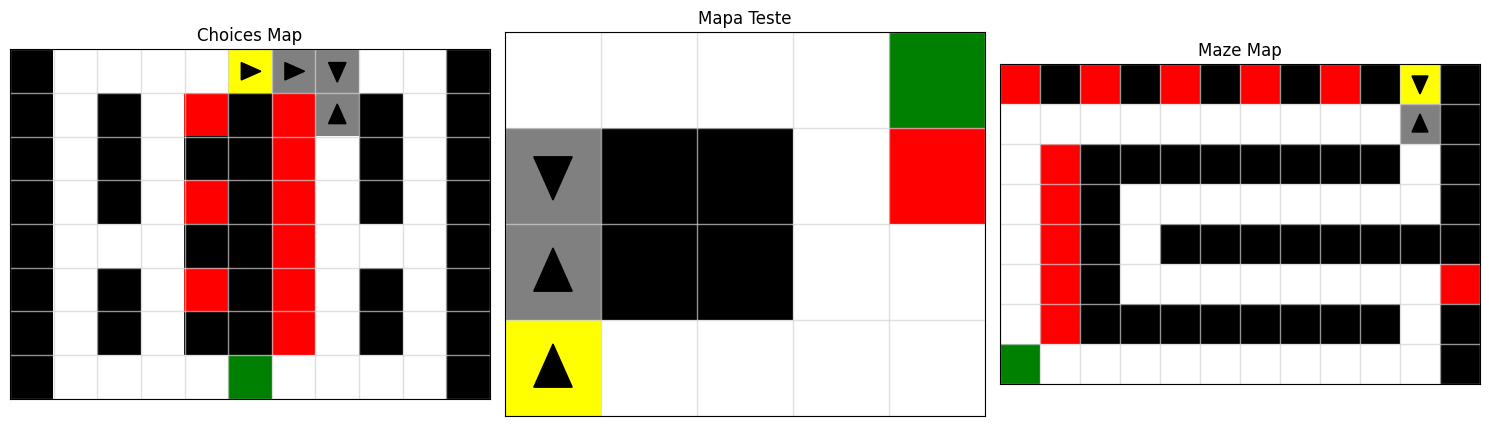

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Call the function for each subplot
plot_path_with_arrows(results['choices.map']['positive'], 0, 5, ax=axes[0])
axes[0].set_title("choices.map")

plot_path_with_arrows(results['mapa_teste.map']['positive'], 3, 0, ax=axes[1])
axes[1].set_title("mapa_teste.map")

plot_path_with_arrows(results['maze.map']['positive'], 0, 10, ax=axes[2])
axes[2].set_title("maze.map")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()